In [1]:
# import libraries
import math
import scipy
import numpy as np
import matplotlib as mpl
import scipy.integrate as integrate
import matplotlib.colors as colors
import matplotlib.cm as cmx
import pandas as pd
import seaborn as sns
from scipy.stats import skewnorm
from scipy.optimize import curve_fit
from scipy.integrate import odeint
%matplotlib inline
import matplotlib.pyplot as plt

import re
import h5py
from scipy.interpolate import interp1d
import glob

from scipy import signal
from scipy import optimize, signal
from symfit import Parameter, Variable
from symfit import Fit
#from symfit import NumericalLeastSquares
from symfit import parameters, variables, D, ODEModel, exp
from symfit.core.minimizers import BasinHopping
#from symfit.core.objectives import LogLikelihood
%matplotlib inline
%config InlineBackend.figure_format = 'svg'


# constants in SI
m_e = 9.10938291E-31 # mass of electron
e_charge = 1.60217657E-19 # charge of electron
eV = 1.60217657E-19 # 1 electron volt in joules
ε_0 = 8.85418782E-12 # permittivity of free space
h = 6.62606957E-34 # planck number
h_ev = 4.135667662E-15 #Plank number eV.s
hbar = 1.054571800E-34 # reduced planck constant
Rydberg = 2.1787E-18 # Rydberg energy (in joules)
avogadro = 6.02214179E23
c = 299792458 # m/s
sigma_ev = 3.54E11 #ev/m^2/s/K^4
sigma = 5.670367E-8 #J/m^2/s/K^4
# units in SI
Å = 1E-10 # m to angstrom
k_b = 1.38064852E-23 #J/K
k_ev = 8.6173303E-5 #ev/K

def peak_max(x_array,y_array, valuerange_low, valuerange_high):
    idx_lo = (np.abs(x_array - valuerange_low)).argmin()
    idx_hi = (np.abs(x_array - valuerange_high)).argmin()
    max_peak = max(y_array[idx_lo:idx_hi])
    return max_peak
def find_nearest_idx(array, value):
    #array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx
def find_zero_idx_range(xarray,y1, y2,xmin,xmax):
    i1 = find_nearest_idx(xarray,xmin)
    i2 = find_nearest_idx(xarray,xmax)
    idx_zero = find_nearest_idx((y1[i1:i2]-y2[i1:i2]),0)
    return idx_zero
def background_f(x_array,y_array, valuerange_low, valuerange_high):
    idx_lo = (np.abs(x_array - valuerange_low)).argmin()
    idx_hi = (np.abs(x_array - valuerange_high)).argmin()
    background_val = np.mean(y_array[idx_lo:idx_hi])
    return background_val

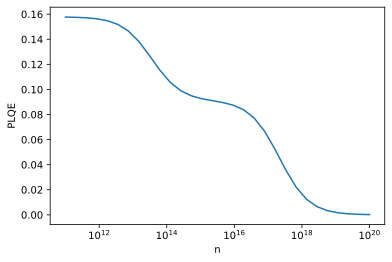

In [2]:
# init_params = OrderedDict([('C_c', 0),
#              ('C_ex', 0),
#              ('b_non', 3.5e-8*1e-12*1e3),
#              ('a_c', 1/1100),
#              ('a_ex_non', 1/345),
#              ('a_ex_rad', 1/3600),
#              ('b_ex', 2.4e-8*1e-12*1e3), 
#              ('a_split', 1/2000),
#              ('b_ex_c', 3.4e-8*1e-12*1e3),
#              ('b_fuse', 3e-8*1e-12*1e3)])
#ts = np.linspace(0, 1e-6, 60)

N_ph = 1e16*np.logspace(1,10,num = 30)*1e-6
#R_init = .45


a_rad = 1/1600
a_non = 1/300
b_rad = 1e-8*1e-12*1e3
b_non = 10e-8*1e-12*1e3
c_non = 0.0000051e-28

n = 1e16*np.logspace(1,10,num = 30)*1e-6

PLQE_int = (a_rad*n+b_rad*n**2)/((a_non+a_rad)*n+(b_rad+b_non)*n**2+c_non*n**3)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(n,PLQE_int)
ax.set_xlabel('n')
ax.set_ylabel('PLQE')
ax.set_xscale('log')
#ax.set_xlim(1e14,1e19)
#fig.savefig('saha.svg', bbox_inches='tight')

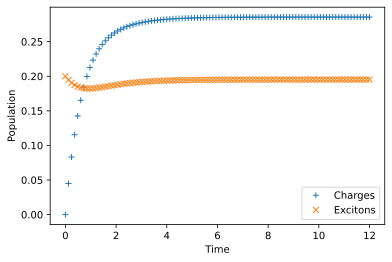

In [3]:
a_c = 1
b_fuse = 1
C_c = 1


a_ex = 1
a_split = 1 
b_ex = 1
C_ex = 1
R_init = 0
a_ex_rad = .1
nn = .2
def dP_dt(P,t):
    return [-(a_c*P[0]+b_fuse*P[0]**2+C_c*P[0]**3-2*a_split*P[1]-nn*R_init),-(a_ex*P[1]+b_ex*P[1]**2+C_ex*P[1]**3-.5*b_fuse*P[0]**2-nn*(1-R_init))]

ts = np.linspace(0, 12, 100)
P0 = [nn*R_init, nn*(1-R_init)]
Ps = odeint(dP_dt, P0, ts)
charges = Ps[:,0]
excitons = Ps[:,1]

plt.plot(ts, charges, "+", label="Charges")
plt.plot(ts, excitons, "x", label="Excitons")
plt.xlabel("Time")
plt.ylabel("Population")
plt.legend();

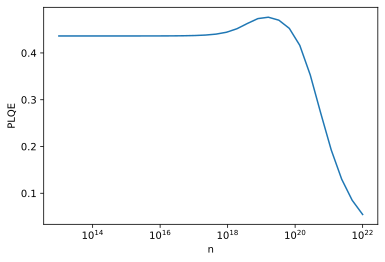

In [4]:
a_c = 1/(650e-12)
b_fuse = 0.95e-11
C_c = .0551e-28

b_ex_c = 0#.495e-11

a_ex = 1/(120e-12)
a_split = 1/100e-12
b_ex = 3.95e-11
C_ex = .0551e-28

a_ex_rad = 1/(110e-12)



def dP_dt(P,t,G):
    G1 = G[0]
    G2 = G[1]
    return [-(a_c*P[0]+b_fuse*P[0]**2+C_c*P[0]**3-2*a_split*P[1]+b_ex_c*P[0]*P[1]-G1),-(b_ex_c*P[0]*P[1]-G2+a_ex*P[1]+b_ex*P[1]**2+C_ex*P[1]**3-.5*b_fuse*P[0]**2)]

ts = np.linspace(0, 1e-6, 20)

N_ph = 1e18*np.logspace(1,10,num = 30)*1e-6
R_init = .6
PLQE_sim = []
charge_ratio = []
for nn in N_ph:
    P0 = [nn*R_init, nn*(1-R_init)]
    G = [P0[0]/600e-12,P0[1]/600e-12]
    Ps = odeint(dP_dt, P0, ts, args = (G,))
    charges = Ps[:,0]
    excitons = Ps[:,1]
    PLQE_theory_n = ((a_ex_rad*excitons)/(a_c*charges+C_c*charges**3+2*b_ex_c*charges*excitons-2*a_split*excitons+.5*b_fuse*charges**2+a_ex*excitons+b_ex*excitons**2+C_ex*excitons**3))
    charge_ratio = np.append(charge_ratio,(charges[-1]/(charges[-1]+excitons[-1])))
    PLQE_sim = np.append(PLQE_sim,PLQE_theory_n[-1])
    
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(N_ph,PLQE_sim)
#ax.plot(N_ph,charge_ratio)
ax.set_xlabel('n')
ax.set_ylabel('PLQE')
ax.set_xscale('log')
#ax.set_xlim(1e14,1e19)  
    

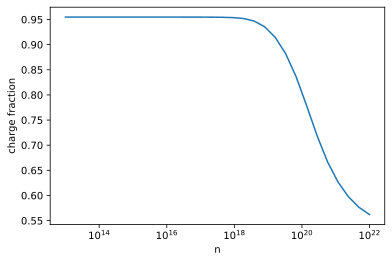

In [5]:
fig = plt.figure()
ax = fig.add_subplot(111)
#ax.plot(ts,charges_1,ts,excitons_1)
#ax.plot(ts[0:end_ts_idx],charges,ts[0:end_ts_idx],excitons)
ax.plot(N_ph,charge_ratio)
ax.set_xlabel('n')
ax.set_ylabel('charge fraction')
ax.set_xscale('log')
#ax.set_yscale('log')


In [6]:
kinetic_data = np.genfromtxt("charge_exciton_kinetics_GA_700nm_just_charge_mask.csv",delimiter=',',skip_header = 1)
tt_data_1 = kinetic_data[:,0]
tt_data_2 = (tt_data_1*np.ones((4,tt_data_1.size))).T

exciton_data = kinetic_data[:,1::2]
charge_data = kinetic_data[:,2::2]

##sort time zeros
tt_data = tt_data_2
tt_data[:,0] = tt_data_2[:,0]-.2
tt_data[:,1] = tt_data_2[:,1]-.12
tt_data[:,2] = tt_data_2[:,2]+.05
tt_data[:,3] = tt_data_2[:,3]#+.1

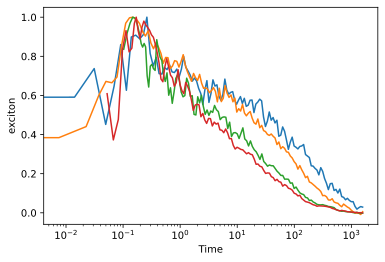

In [7]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(tt_data,exciton_data/np.ndarray.max(exciton_data,0))
ax.set_xlabel('Time')
ax.set_ylabel('exciton')
#ax.set_xlim(0,200)
ax.set_xscale('log')

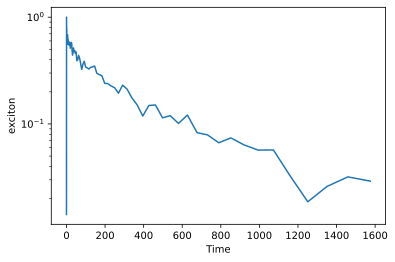

In [8]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(tt_data[:,0],exciton_data[:,0]/max(exciton_data[:,0]))
ax.set_xlabel('Time')
ax.set_ylabel('exciton')
#ax.set_xlim(0,2000)
ax.set_yscale('log')

t_0 = 0.5 #set time to model from

norm_mult = 1.02

t_0_idx = find_nearest_idx(tt_data[:,0],t_0)
exciton_1 = norm_mult*exciton_data[t_0_idx:,0]/max(exciton_data[t_0_idx:,0])
exciton_2 = norm_mult*exciton_data[t_0_idx:,1]/max(exciton_data[t_0_idx:,1])
exciton_3 = norm_mult*exciton_data[t_0_idx:,2]/max(exciton_data[t_0_idx:,2])
t_data1 = (tt_data[t_0_idx:,0]-t_0)*1e-12
charge_1 = norm_mult*charge_data[t_0_idx:,0]/max(charge_data[t_0_idx:,0])
charge_2 = norm_mult*charge_data[t_0_idx:,1]/max(charge_data[t_0_idx:,1])
charge_3 = norm_mult*charge_data[t_0_idx:,2]/max(charge_data[t_0_idx:,2])
R_init_guess = max(charge_data[t_0_idx:,0])/(max(exciton_data[t_0_idx:,0])+max(charge_data[t_0_idx:,0]))

In [9]:
R_init_guess

0.5901669856763317

In [10]:
import win32clipboard as clipboard

def toClipboardForExcel(array):
    """
    Copies an array into a string format acceptable by Excel.
    Columns separated by \t, rows separated by \n
    """
    # Create string from array
    line_strings = []
    for line in array:
        line_strings.append("\t".join(line.astype(str)).replace("\n",""))
    array_string = "\r\n".join(line_strings)

    # Put string into clipboard (open, clear, set, close)
    clipboard.OpenClipboard()
    clipboard.EmptyClipboard()
    clipboard.SetClipboardText(array_string)
    clipboard.CloseClipboard()

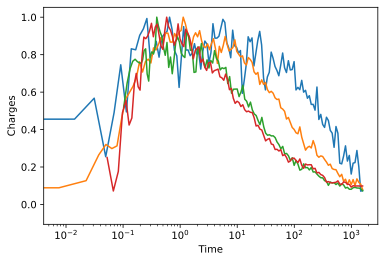

In [11]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(tt_data,charge_data/np.ndarray.max(charge_data,0))
ax.set_xlabel('Time')
ax.set_ylabel('Charges')
ax.set_xscale('log')

In [12]:
toClipboardForExcel(exciton_data)

(0.0001, 0.015)

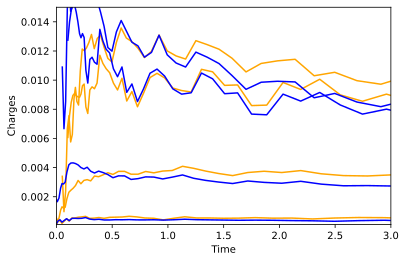

In [13]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(tt_data,charge_data,color = 'orange')
ax.plot(tt_data,exciton_data,color = 'blue')
ax.set_xlabel('Time')
ax.set_ylabel('Charges')
#ax.set_yscale('log')
ax.set_xlim(0,3)
ax.set_ylim(1e-4,0.015)

In [14]:
t_data1 = (tt_data[t_0_idx:,0]-t_0)*1e-12

a_c = Parameter('a_c',value =1/(1200e-12),min = 0, fixed =True)
b_fuse = Parameter('b_fuse', value = 1.15e-11,min = 0,fixed = False)
C_c = Parameter('C_c', value =0,min = 0,fixed = True)#.000551e-28,min = 0,fixed = True)
b_ex_c = Parameter('b_ex_c', value = 0,min = 0,fixed = True)#.495e-11,min = 0,fixed = False)
a_ex =Parameter('a_ex', value = 1/(280e-12),min = 0,fixed = True)#1/(280)
a_split = Parameter('a_split', value =1/(4000e-12),min = 0,fixed = True)#1/(120e-12)
b_ex = Parameter('b_ex', value = 1.6e-11,min = 0,fixed = False)#4.2e-11
C_ex = Parameter('C_ex',value = 0,min = 0,fixed = True)#.000551e-28,min = 0,fixed = True)
a_ex_rad = Parameter('a_ex_rad',value =0,min = 0,fixed = True)#1e6,min = 0,fixed = True)

charges1,excitons1,t,charges2,excitons2,charges3,excitons3 = variables('charges1,excitons1,t,charges2,excitons2,charges3,excitons3')

wavelength = 700e-9
thickness = 110e-9
k = 1.3 #from kerremans, Armin et al. 
alpha = 4*np.pi*k/wavelength
OD = -np.log10(np.exp(-alpha*thickness))
absorb = (1-10**(-OD))
reprate = 3000
FWHM = 400e-6
power1 = 0.8e-6
power2 = 4.5e-6
power3 = 18e-6
nn1 = (absorb*0.85*power1/((h*c/wavelength)*np.pi*(FWHM/2)**2*thickness))*1e-6
nn2 = (absorb*0.85*power2/((h*c/wavelength)*np.pi*(FWHM/2)**2*thickness))*1e-6
nn3 = (absorb*0.85*power3/((h*c/wavelength)*np.pi*(FWHM/2)**2*thickness))*1e-6


R_init = 0.3#R_init_guess
charge_data1 = nn1*R_init*charge_1
exciton_data1 = nn1*(1-R_init)*exciton_1
charge_data2 = nn2*R_init*charge_2
exciton_data2 = nn2*(1-R_init)*exciton_2
charge_data3 = nn3*R_init*charge_3
exciton_data3 = nn3*(1-R_init)*exciton_3

data = [charge_data1,charge_data2,charge_data3,exciton_data1,exciton_data2,exciton_data3]
values = range(len(data))
#a_c,b_fuse,C_c, b_ex_c,a_ex,a_split,b_ex,C_ex = parameters('a_c,b_fuse,C_c, b_ex_c,a_ex,a_split,b_ex,C_ex')


model = {
    D(charges1,t):  -(a_c*charges1+b_fuse*charges1**2+C_c*charges1**3-2*a_split*excitons1+b_ex_c*charges1*excitons1),
    D(excitons1,t): -(b_ex_c*charges1*excitons1+a_ex*excitons1+b_ex*excitons1**2+C_ex*excitons1**3-.5*b_fuse*charges1**2),
    D(charges2,t):  -(a_c*charges2+b_fuse*charges2**2+C_c*charges2**3-2*a_split*excitons2+b_ex_c*charges2*excitons2),
    D(excitons2,t): -(b_ex_c*charges2*excitons2+a_ex*excitons2+b_ex*excitons2**2+C_ex*excitons2**3-.5*b_fuse*charges2**2),
    D(charges3,t):  -(a_c*charges3+b_fuse*charges3**2+C_c*charges3**3-2*a_split*excitons3+b_ex_c*charges3*excitons3),
    D(excitons3,t): -(b_ex_c*charges3*excitons3+a_ex*excitons3+b_ex*excitons3**2+C_ex*excitons3**3-.5*b_fuse*charges3**2),
}

ode_model = ODEModel(model, initial={t: 0, charges1: nn1*R_init, excitons1:nn1*(1-R_init),charges2: nn2*R_init, excitons2:nn2*(1-R_init),charges3: nn3*R_init, excitons3:nn3*(1-R_init)})


fit = Fit(ode_model, t=t_data1,charges1 = charge_data1, excitons1 = exciton_data1,charges2 = charge_data2, excitons2 = exciton_data2,charges3 = charge_data3, excitons3= exciton_data3)
fit_result = fit.execute()
print(fit_result)
model_fit = ode_model(t=t_data1, **fit_result.params)._asdict()
#plt.scatter(t_data1*1e12, charge_data1)
#plt.scatter(t_data1*1e12, exciton_data1)
#plt.plot(t_data1*1e12, charges_fit, label='Charges')
#plt.plot(t_data1*1e12, excitons_fit, label='Excitons')
    

C:\Users\pricemi.STAFF\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)



Parameter Value        Standard Deviation
C_c       0.000000e+00 1.895689e-13
C_ex      0.000000e+00 3.634108e-19
a_c       8.333333e+08 2.641467e+09
a_ex      3.571429e+09 1.533973e+09
a_split   2.500000e+08 1.229311e+09
b_ex      1.600000e-11 7.469447e-18
b_ex_c    0.000000e+00 1.728344e-17
b_fuse    1.150000e-11 6.255295e-22
Status message         b'ABNORMAL_TERMINATION_IN_LNSRCH'
Number of iterations   0
Objective              <symfit.core.objectives.LeastSquares object at 0x000001CD8EA72610>
Minimizer              <symfit.core.minimizers.LBFGSB object at 0x000001CD8EA72A30>

Goodness of fit qualifiers:
chi_squared            9.460439080751621e+42
objective_value        4.730219540375811e+42
r_squared              0.8871705626752702


C:\Users\pricemi\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.


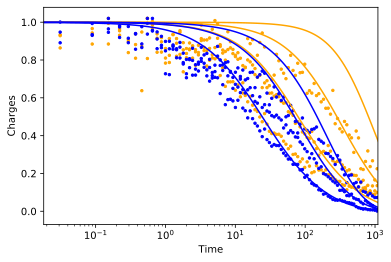

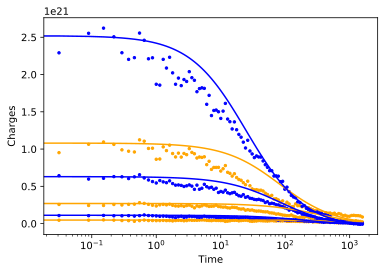

In [50]:
fig = plt.figure()
ax = fig.add_subplot(111)
values = range(len(data))
for idx in values:
    if (idx<3):
        ax.scatter(t_data1*1e12, norm_mult*data[idx]/max(data[idx]),color = 'orange',s = 6)
    else:
        ax.scatter(t_data1*1e12, norm_mult*data[idx]/max(data[idx]),color = 'blue',s = 6)
for var in model_fit:
    if (var == charges1):
        ax.plot(t_data1*1e12, model_fit[var]/max(model_fit[var]),color = 'orange')
    elif(var == charges2):
        ax.plot(t_data1*1e12, model_fit[var]/max(model_fit[var]),color = 'orange')
    elif(var == charges3):
        ax.plot(t_data1*1e12, model_fit[var]/max(model_fit[var]),color = 'orange')
    else:
        ax.plot(t_data1*1e12, model_fit[var]/max(model_fit[var]),color = 'blue')
ax.set_xlabel('Time')
ax.set_ylabel('Charges')
ax.set_xscale('log')
ax.set_xlim(0,1100)

fig = plt.figure()
ax = fig.add_subplot(111)
values = range(len(data))
for idx in values:
    if (idx<3):
        ax.scatter(t_data1*1e12, norm_mult*data[idx],color = 'orange',s = 6)
    else:
        ax.scatter(t_data1*1e12, norm_mult*data[idx],color = 'blue',s = 6)
for var in model_fit:
    if (var == charges1):
        ax.plot(t_data1*1e12, model_fit[var],color = 'orange')
    elif(var == charges2):
        ax.plot(t_data1*1e12, model_fit[var],color = 'orange')
    elif(var == charges3):
        ax.plot(t_data1*1e12, model_fit[var],color = 'orange')
    else:
        ax.plot(t_data1*1e12, model_fit[var],color = 'blue')
ax.set_xlabel('Time')
ax.set_ylabel('Charges')
ax.set_xscale('log')
#ax.set_ylim(0,.5e22)
#ax.set_xlim(-.1,2)

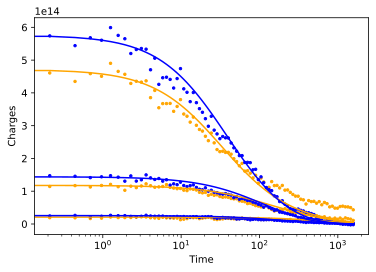

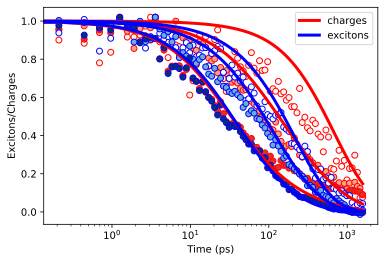

In [15]:
#change units to mm^3 ps-1 rather than cm^3 s-1
t_0 = 2.5 #set time to model from

norm_mult = 1.02

t_0_idx = find_nearest_idx(tt_data[:,0],t_0)
exciton_1 = norm_mult*exciton_data[t_0_idx:,0]/max(exciton_data[t_0_idx:,0])
exciton_2 = norm_mult*exciton_data[t_0_idx:,1]/max(exciton_data[t_0_idx:,1])
exciton_3 = norm_mult*exciton_data[t_0_idx:,2]/max(exciton_data[t_0_idx:,2])
t_data1 = (tt_data[t_0_idx:,0]-t_0)*1e-12
charge_1 = norm_mult*charge_data[t_0_idx:,0]/max(charge_data[t_0_idx:,0])
charge_2 = norm_mult*charge_data[t_0_idx:,1]/max(charge_data[t_0_idx:,1])
charge_3 = norm_mult*charge_data[t_0_idx:,2]/max(charge_data[t_0_idx:,2])



t_data1 = (tt_data[t_0_idx:,0]-t_0)
a_c = Parameter('a_c',value =1/(1030),min = 0,absolute_sigma = False, fixed =True)
b_fuse = Parameter('b_fuse', value = 0.5e-8*1e-12*1e3,min = 0,absolute_sigma = False, fixed = True)#1.45e-11*1e12
b_non = Parameter('b_non', value = 1e-8*1e-12*1e3,min = 0,absolute_sigma = False, fixed = False)#1.45e-11*1e12
C_c = Parameter('C_c', value =0,min = 0,fixed = True)#.000551e-28,min = 0,fixed = True)
b_ex_c = Parameter('b_ex_c', value = 1e-8*1e-12*1e3,min = 0,absolute_sigma = False,fixed = True)#.495e-11,min = 0,fixed = False)
a_ex_non =Parameter('a_ex_non', value = (1/(395)),min = 0,absolute_sigma = False,fixed = False)#1/(280)
a_split = Parameter('a_split', value =(1/(1200)),min = 0,absolute_sigma = False,fixed = True)#1/(120e-12)
b_ex = Parameter('b_ex', value = 0.2e-8*1e-12*1e3,min = 0,absolute_sigma = False,fixed = True)##2.2e-11*1e12
C_ex = Parameter('C_ex',value = 0,min = 0,fixed = True)#.000551e-28,min = 0,fixed = True)
a_ex_rad = Parameter('a_ex_rad',value =1/3400,min = 0,fixed = True)#1e6,min = 0,fixed = True)

b_ex_init = 0#6e-8*1e-12*1e3
t_ann_ex = 10
b_fuse_init = 0#2.3e-8*1e-12*1e3
t_ann_c = 5

charges1,excitons1,t,charges2,excitons2,charges3,excitons3 = variables('charges1,excitons1,t,charges2,excitons2,charges3,excitons3')

wavelength = 700e-9
thickness = 130e-9
k = 1.3 #from kerremans, Armin et al. 
alpha = 4*np.pi*k/wavelength
OD = -np.log10(np.exp(-alpha*thickness))
absorb = (1-10**(-OD))
reprate = 3000
FWHM = 400e-6
power1 = 0.8e-6
power2 = 4.5e-6
power3 = 18e-6
nn1 = absorb*0.85*power1/((h*c/wavelength)*np.pi*(FWHM/2)**2*thickness*reprate)*1e-9
nn2 = absorb*0.85*power2/((h*c/wavelength)*np.pi*(FWHM/2)**2*thickness*reprate)*1e-9
nn3 = absorb*0.85*power3/((h*c/wavelength)*np.pi*(FWHM/2)**2*thickness*reprate)*1e-9


R_init = 0.45#R_init_guess
charge_data1 = nn1*R_init*charge_1
exciton_data1 = nn1*(1-R_init)*exciton_1
charge_data2 = nn2*R_init*charge_2
exciton_data2 = nn2*(1-R_init)*exciton_2
charge_data3 = nn3*R_init*charge_3
exciton_data3 = nn3*(1-R_init)*exciton_3

data = [charge_data1,charge_data2,charge_data3,exciton_data1,exciton_data2,exciton_data3]
values = range(len(data))
#a_c,b_fuse,C_c, b_ex_c,a_ex,a_split,b_ex,C_ex = parameters('a_c,b_fuse,C_c, b_ex_c,a_ex,a_split,b_ex,C_ex')


model = {
    D(charges1,t):  -(a_c*charges1+((b_fuse_init*exp(-t/t_ann_c)+b_fuse)+b_non)*charges1**2+C_c*charges1**3-2*a_split*excitons1+0*charges1*excitons1),
    D(excitons1,t): -(b_ex_c*charges1*excitons1+(a_ex_non+a_split+a_ex_rad)*excitons1+(b_ex_init*exp(-t/t_ann_ex)+b_ex)*excitons1**2+C_ex*excitons1**3-.5*b_fuse*charges1**2),
    D(charges2,t):  -(a_c*charges2+((b_fuse_init*exp(-t/t_ann_c)+b_fuse)+b_non)*charges2**2+C_c*charges2**3-2*a_split*excitons2+0*charges2*excitons2),
    D(excitons2,t): -(b_ex_c*charges2*excitons2+(a_ex_non+a_split+a_ex_rad)*excitons2+(b_ex_init*exp(-t/t_ann_ex)+b_ex)*excitons2**2+C_ex*excitons2**3-.5*b_fuse*charges2**2),
    D(charges3,t):  -(a_c*charges3+((b_fuse_init*exp(-t/t_ann_c)+b_fuse)+b_non)*charges3**2+C_c*charges3**3-2*a_split*excitons3+0*charges3*excitons3),
    D(excitons3,t): -(b_ex_c*charges3*excitons3+(a_ex_non+a_split+a_ex_rad)*excitons3+(b_ex_init*exp(-t/t_ann_ex)+b_ex)*excitons3**2+C_ex*excitons3**3-.5*b_fuse*charges3**2),
}

ode_model = ODEModel(model, initial={t: 0, charges1: nn1*R_init, excitons1:nn1*(1-R_init),charges2: nn2*R_init, excitons2:nn2*(1-R_init),charges3: nn3*R_init, excitons3: nn3*(1-R_init)})

#guess = InteractiveGuess(ode_model, t=t_data1,charges1 = charge_data1, excitons1 = exciton_data1,charges2 = charge_data2, excitons2 = exciton_data2,charges3 = charge_data3, excitons3= exciton_data3, n_points=20)
#guess.execute()
#print(guess)

#fit = Fit(ode_model, t=t_data1,charges1 = charge_data1, excitons1 = exciton_data1,charges2 = charge_data2, excitons2 = exciton_data2,charges3 = charge_data3, excitons3= exciton_data3,absolute_sigma=False)# minimizer=BasinHopping)
#fit_result = fit.execute()
#print(fit_result)
from collections import OrderedDict
init_params = OrderedDict([('C_c', 0),
             ('C_ex', 0),
             ('b_non', 3.5e-8*1e-12*1e3),
             ('a_c', 1/1100),
             ('a_ex_non', 1/345),
             ('a_ex_rad', 1/3600),
             ('b_ex', 2.4e-8*1e-12*1e3), 
             ('a_split', 1/2000),
             ('b_ex_c', 3.4e-8*1e-12*1e3),
             ('b_fuse', 3e-8*1e-12*1e3)])

model_fit = ode_model(t=t_data1, **init_params)._asdict()

fig = plt.figure()
ax = fig.add_subplot(111)
values = range(len(data))
for idx in values:
    if (idx<3):
        ax.scatter(t_data1, norm_mult*data[idx],color = 'orange',s = 6)
    else:
        ax.scatter(t_data1, norm_mult*data[idx],color = 'blue',s = 6)
for var in model_fit:
    if (var == charges1):
        ax.plot(t_data1, model_fit[var],color = 'orange')
    elif(var == charges2):
        ax.plot(t_data1, model_fit[var],color = 'orange')
    elif(var == charges3):
        ax.plot(t_data1, model_fit[var],color = 'orange')
    else:
        ax.plot(t_data1, model_fit[var],color = 'blue')
ax.set_xlabel('Time')
ax.set_ylabel('Charges')
ax.set_xscale('log')
#ax.set_ylim(0,.5e22)
#ax.set_xlim(-.1,2)


fig = plt.figure()
ax = fig.add_subplot(111)
Reds = cm = plt.get_cmap('Reds') 
cNorm  = colors.Normalize(vmin=0, vmax=values[3])
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=Reds)
lines = []
for idx in values[0:3]:
    colorVal = scalarMap.to_rgba(values[idx])
            #colorText = (ratios_absorption[idx])
    retLine = ax.scatter(t_data1, norm_mult*data[idx]/max(data[idx]),
            facecolors=colorVal, edgecolors = 'r')#,s = 8)
                       #label=colorText)
    lines.append(retLine)
Blues = cm = plt.get_cmap('Blues') 
cNorm  = colors.Normalize(vmin=3, vmax=values[5])
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=Blues)
lines = []
for idx in values[3::]:
    colorVal = scalarMap.to_rgba(values[idx])
            #colorText = (ratios_absorption[idx])
    retLine = ax.scatter(t_data1, norm_mult*data[idx]/max(data[idx]),
            facecolors=colorVal, edgecolors = 'b')#,s = 8)
                       #label=colorText)
    lines.append(retLine)
      
    
for var in model_fit:
    if (var == charges1):
        ax.plot(t_data1, model_fit[var]/max(model_fit[var]),label = 'charges',color = 'red', lw = 3)
    elif(var == charges2):
        ax.plot(t_data1, model_fit[var]/max(model_fit[var]),color = 'red', lw = 3)
    elif(var == charges3):
        ax.plot(t_data1, model_fit[var]/max(model_fit[var]),color = 'red', lw = 3)
    elif(var == excitons1):
        ax.plot(t_data1, model_fit[var]/max(model_fit[var]),color = 'blue', lw = 3)
    elif(var == excitons2):
        ax.plot(t_data1, model_fit[var]/max(model_fit[var]),color = 'blue', lw = 3)
    else:
        ax.plot(t_data1, model_fit[var]/max(model_fit[var]),label = 'excitons',color = 'blue', lw = 3)
ax.set_xlabel('Time (ps)')
ax.set_ylabel('Excitons/Charges')
ax.set_xscale('log')
ax.legend()
#fig.savefig('TA_glob_fit.svg', bbox_inches='tight')
#ax.set_xlim(0,1100)

    

<ipython-input-121-2a2a8aebe6f9>:140: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_xlim(0,1550)
<ipython-input-121-2a2a8aebe6f9>:207: RuntimeWarning: invalid value encountered in true_divide
  PLQE_theory_n = ((a_ex_rad*excitons+p_frac*b_fuse*charges**2)/(a_c*charges+C_c*charges**3+b_ex_c*charges*excitons-a_split*excitons+(b_non+b_fuse)*charges**2-.5*(1-p_frac)*b_fuse*charges**2+a_ex*excitons+0.5*b_ex*excitons**2+C_ex*excitons**3))


(10000000000000.0, 1e+18)

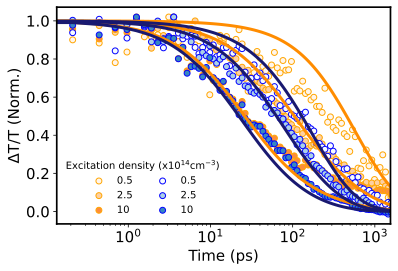

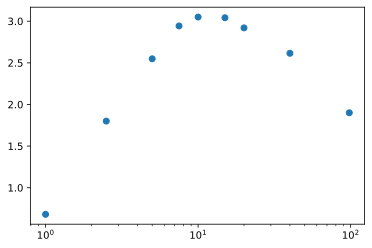

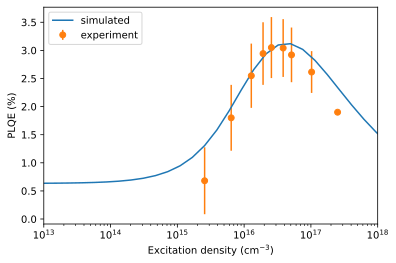

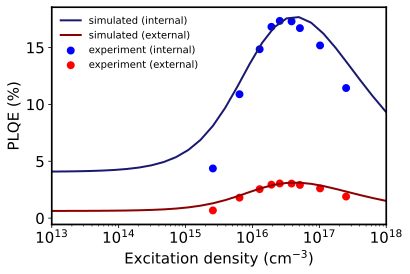

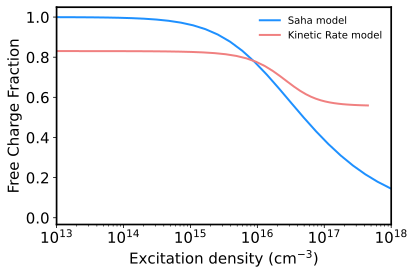

In [121]:
#change units to mm^3 ps-1 rather than cm^3 s-1
t_0 = 2.5 #set time to model from

norm_mult = 1.02

t_0_idx = find_nearest_idx(tt_data[:,0],t_0)
exciton_1 = norm_mult*exciton_data[t_0_idx:,0]/max(exciton_data[t_0_idx:,0])
exciton_2 = norm_mult*exciton_data[t_0_idx:,1]/max(exciton_data[t_0_idx:,1])
exciton_3 = norm_mult*exciton_data[t_0_idx:,2]/max(exciton_data[t_0_idx:,2])
t_data1 = (tt_data[t_0_idx:,0]-t_0)*1e-12
charge_1 = norm_mult*charge_data[t_0_idx:,0]/max(charge_data[t_0_idx:,0])
charge_2 = norm_mult*charge_data[t_0_idx:,1]/max(charge_data[t_0_idx:,1])
charge_3 = norm_mult*charge_data[t_0_idx:,2]/max(charge_data[t_0_idx:,2])



t_data1 = (tt_data[t_0_idx:,0]-t_0)
a_c = Parameter('a_c',value =1/(1030),min = 0,absolute_sigma = False, fixed =True)
b_fuse = Parameter('b_fuse', value = 0.5e-8*1e-12*1e3,min = 0,absolute_sigma = False, fixed = True)#1.45e-11*1e12
b_non = Parameter('b_non', value = 1e-8*1e-12*1e3,min = 0,absolute_sigma = False, fixed = False)#1.45e-11*1e12
C_c = Parameter('C_c', value =0,min = 0,fixed = True)#.000551e-28,min = 0,fixed = True)
b_ex_c = Parameter('b_ex_c', value = 1e-8*1e-12*1e3,min = 0,absolute_sigma = False,fixed = True)#.495e-11,min = 0,fixed = False)
a_ex_non =Parameter('a_ex_non', value = (1/(395)),min = 0,absolute_sigma = False,fixed = False)#1/(280)
a_split = Parameter('a_split', value =(1/(1200)),min = 0,absolute_sigma = False,fixed = True)#1/(120e-12)
b_ex = Parameter('b_ex', value = 0.2e-8*1e-12*1e3,min = 0,absolute_sigma = False,fixed = True)##2.2e-11*1e12
C_ex = Parameter('C_ex',value = 0,min = 0,fixed = True)#.000551e-28,min = 0,fixed = True)
a_ex_rad = Parameter('a_ex_rad',value =1/3400,min = 0,fixed = True)#1e6,min = 0,fixed = True)

b_ex_init = 0#6e-8*1e-12*1e3
t_ann_ex = 10
b_fuse_init = 0#2.3e-8*1e-12*1e3
t_ann_c = 5

charges1,excitons1,t,charges2,excitons2,charges3,excitons3 = variables('charges1,excitons1,t,charges2,excitons2,charges3,excitons3')

wavelength = 700e-9
thickness = 130e-9
k = 1.3 #from kerremans, Armin et al. 
alpha = 4*np.pi*k/wavelength
OD = -np.log10(np.exp(-alpha*thickness))
absorb = (1-10**(-OD))
reprate = 1500
FWHM = 400e-6
power1 = 0.8e-6
power2 = 4.5e-6
power3 = 18e-6
nn1 = absorb*0.85*power1/((h*c/wavelength)*np.pi*(FWHM/2)**2*thickness*reprate)*1e-9
nn2 = absorb*0.85*power2/((h*c/wavelength)*np.pi*(FWHM/2)**2*thickness*reprate)*1e-9
nn3 = absorb*0.85*power3/((h*c/wavelength)*np.pi*(FWHM/2)**2*thickness*reprate)*1e-9


R_init = 0.45#R_init_guess
charge_data1 = nn1*R_init*charge_1
exciton_data1 = nn1*(1-R_init)*exciton_1
charge_data2 = nn2*R_init*charge_2
exciton_data2 = nn2*(1-R_init)*exciton_2
charge_data3 = nn3*R_init*charge_3
exciton_data3 = nn3*(1-R_init)*exciton_3

data = [charge_data1,charge_data2,charge_data3,exciton_data1,exciton_data2,exciton_data3]
values = range(len(data))
#a_c,b_fuse,C_c, b_ex_c,a_ex,a_split,b_ex,C_ex = parameters('a_c,b_fuse,C_c, b_ex_c,a_ex,a_split,b_ex,C_ex')


model = {
    D(charges1,t):  -(a_c*charges1+((b_fuse_init*exp(-t/t_ann_c)+b_fuse)+b_non)*charges1**2+C_c*charges1**3-2*a_split*excitons1+0*charges1*excitons1),
    D(excitons1,t): -(b_ex_c*charges1*excitons1+(a_ex_non+a_split+a_ex_rad)*excitons1+(b_ex_init*exp(-t/t_ann_ex)+b_ex)*excitons1**2+C_ex*excitons1**3-.5*b_fuse*charges1**2),
    D(charges2,t):  -(a_c*charges2+((b_fuse_init*exp(-t/t_ann_c)+b_fuse)+b_non)*charges2**2+C_c*charges2**3-2*a_split*excitons2+0*charges2*excitons2),
    D(excitons2,t): -(b_ex_c*charges2*excitons2+(a_ex_non+a_split+a_ex_rad)*excitons2+(b_ex_init*exp(-t/t_ann_ex)+b_ex)*excitons2**2+C_ex*excitons2**3-.5*b_fuse*charges2**2),
    D(charges3,t):  -(a_c*charges3+((b_fuse_init*exp(-t/t_ann_c)+b_fuse)+b_non)*charges3**2+C_c*charges3**3-2*a_split*excitons3+0*charges3*excitons3),
    D(excitons3,t): -(b_ex_c*charges3*excitons3+(a_ex_non+a_split+a_ex_rad)*excitons3+(b_ex_init*exp(-t/t_ann_ex)+b_ex)*excitons3**2+C_ex*excitons3**3-.5*b_fuse*charges3**2),
}

ode_model = ODEModel(model, initial={t: 0, charges1: nn1*R_init, excitons1:nn1*(1-R_init),charges2: nn2*R_init, excitons2:nn2*(1-R_init),charges3: nn3*R_init, excitons3: nn3*(1-R_init)})

#guess = InteractiveGuess(ode_model, t=t_data1,charges1 = charge_data1, excitons1 = exciton_data1,charges2 = charge_data2, excitons2 = exciton_data2,charges3 = charge_data3, excitons3= exciton_data3, n_points=20)
#guess.execute()
#print(guess)

#fit = Fit(ode_model, t=t_data1,charges1 = charge_data1, excitons1 = exciton_data1,charges2 = charge_data2, excitons2 = exciton_data2,charges3 = charge_data3, excitons3= exciton_data3,absolute_sigma=False)# minimizer=BasinHopping)
#fit_result = fit.execute()
#print(fit_result)
from collections import OrderedDict
init_params = OrderedDict([('C_c', 0),
             ('C_ex', 0),
             ('b_non', 0.1e-8*1e-12*1e3),
             ('a_c', 1/1100),
             ('a_ex_non', 1/295),
             ('a_ex_rad', 1/3000),
             ('b_ex', 2.6e-8*1e-12*1e3), 
             ('a_split', 1/2000),
             ('b_ex_c', 2.6e-8*1e-12*1e3),
             ('b_fuse', 4e-8*1e-12*1e3)])

model_fit = ode_model(t=t_data1, **init_params)._asdict()


colorText = ['0.5','2.5','10']
fig = plt.figure()
ax = fig.add_subplot(111)
ax.tick_params(axis='both', which='major', labelsize=15)
values = range(len(data))
Reds = cm = plt.get_cmap('Oranges') 
cNorm  = colors.Normalize(vmin=0, vmax=values[3]+1)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=Reds)
lines = []
for idx in values[0:3]:
    colorVal = scalarMap.to_rgba(values[idx])
            #colorText = (ratios_absorption[idx])
    retLine = ax.scatter(t_data1, norm_mult*data[idx]/max(data[idx]),
            facecolors=colorVal, edgecolors = 'orange',
                       label=colorText[idx])
    lines.append(retLine)
Blues = cm = plt.get_cmap('Blues') 
cNorm  = colors.Normalize(vmin=3, vmax=values[5]+1)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=Blues)
lines = []
for idx in values[3::]:
    colorVal = scalarMap.to_rgba(values[idx])
            #colorText = (ratios_absorption[idx])
    retLine = ax.scatter(t_data1, norm_mult*data[idx]/max(data[idx]),
            facecolors=colorVal, edgecolors = 'b',
                       label=colorText[idx-3])
    lines.append(retLine)
        
ax.plot(t_data1, (model_fit[charges1])/max(model_fit[charges1]),color = 'darkorange', linewidth = 3)
ax.plot(t_data1, (model_fit[charges2])/max(model_fit[charges2]),color = 'darkorange', linewidth = 3)
ax.plot(t_data1, (model_fit[charges3])/max(model_fit[charges3]),color = 'darkorange', linewidth = 3)

ax.plot(t_data1, model_fit[excitons1]/max(model_fit[excitons1]),color = 'midnightblue', linewidth = 3)
ax.plot(t_data1, model_fit[excitons2]/max(model_fit[excitons2]),color = 'midnightblue', linewidth = 3)
ax.plot(t_data1, model_fit[excitons3]/max(model_fit[excitons3]),color = 'midnightblue', linewidth = 3)
for i in iter(ax.spines.values()):
    i.set_linewidth(1.7) 
handles,labels = ax.get_legend_handles_labels()
ax.legend(frameon = False, ncol = 2,title="Excitation density (x10$^{14}$cm$^{-3}$)")#loc='lower right'
ax.set_xlabel('Time (ps)',fontsize = 15)
ax.set_ylabel('$\Delta$T/T (Norm.)',fontsize = 15)
ax.set_xscale('log')
ax.set_xlim(0,1550)
fig.savefig('TA_glob_fit_no_CT.svg',bbox_inches='tight')


PLQE_data_init = np.genfromtxt('Y6_Old_film_good_PLQE_fluence.csv',delimiter=',')
PLQE_power = PLQE_data_init[:,0]
PLQE_data = 3.05*PLQE_data_init[:,1]/max(PLQE_data_init[:,1])
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(PLQE_power,PLQE_data)
ax.set_xscale('log')

wavelength = 530e-9
thickness = 150e-9
k = .85 #from kerremans, Armin et al. 
alpha = 4*np.pi*k/wavelength
OD = -np.log10(np.exp(-alpha*thickness))
absorb = (1-10**(-OD))
reprate = 25000
FWHM = 0.58e-3
power_steady = PLQE_power*1e-6
nn_data = absorb*power_steady/((h*c/wavelength)*np.pi*(FWHM/2)**2*thickness*reprate)*1e-6


C_c = 35e-25#list(init_params.values())[0]  #.00002e-28
C_ex = 85e-25#list(init_params.values())[1] #0.00002e-28
b_non = list(init_params.values())[2]*1e9
a_c = list(init_params.values())[3]*1e12  #1/(1030e-12)
a_ex_non_rad = list(init_params.values())[4]*1e12  #1/(510e-12)
a_ex_rad = list(init_params.values())[5]*1e12  #1/(1200e-12)
b_ex = list(init_params.values())[6]*1e9  #5500e-11
a_split = list(init_params.values())[7]*1e12 #1/(500e-12)
b_ex_c = list(init_params.values())[8]*1e9 #100e-11
b_fuse = list(init_params.values())[9]*1e9# 1.7e-8

eta_esc= .15

# R_init_S = 0.7#R_init_guess
# fc_ratio = 0.001
#     D(excitons1,t): -(a_s_non+a_s_split+a_s_rad)*excitons1-b_s*excitons1**2-b_s_fc*excitons1*(fc1+ct_s1+ct_t1)+a_ct_join*ct_s1,
#     D(ct_s1,t):  -(a_ct_non+a_ct_join+a_ct_split)*ct_s1-b_ct*ct_s1**2-b_s_fc*excitons1*ct_s1+.25*b_fuse*fc1**2+a_s_split*excitons1,
#     D(ct_t1,t): -(a_ct_non+a_ct_split)*ct_t1-b_ct*ct_t1**2-b_s_fc*excitons1*ct_t1+.75*b_fuse*fc1**2,
#     D(fc1,t):  -a_fc_non*fc1-b_fuse*fc1**2+2*a_ct_split*(ct_s1+ct_t1),
#         excitons1:nn1*(1-R_init), ct_s1: nn1*(R_init-(.9*R_init)), ct_t1: .05*R_init, fc1:.05*R_init

a_ex = a_split+a_ex_rad+a_ex_non_rad

def dP_dt(P,t,G):
    G1 = G[0]
    G2 = G[1]
    return [-(a_c*P[0]+(b_fuse+b_non)*P[0]**2-0.5*b_ex*P[1]**2+C_c*P[0]**3-2*a_split*P[1]-b_ex_c*P[0]*P[1]-G1),-(b_ex_c*P[0]*P[1]-G2+a_ex*P[1]+b_ex*P[1]**2+C_ex*P[1]**3-.5*(1-p_frac)*b_fuse*P[0]**2)]

ts = np.linspace(0, 100e-9, 50000)

N_ph = 1e16*np.logspace(1,10,num = 50)*1e-6

p_frac = 1
R_init = .45
PLQE_sim = []
charge_ratio = []
carrier_tot = []
for nn in N_ph:
    P0 = [0, 0]#P0 = [nn*R_init, nn*(1-R_init)]
    G = [nn*R_init/800e-12,nn*(1-R_init)/800e-12]
    Ps = odeint(dP_dt, P0, ts, args = (G,))
    charges = Ps[:,0]
    excitons = Ps[:,1]
    PLQE_theory_n = ((a_ex_rad*excitons+p_frac*b_fuse*charges**2)/(a_c*charges+C_c*charges**3+b_ex_c*charges*excitons-a_split*excitons+(b_non+b_fuse)*charges**2-.5*(1-p_frac)*b_fuse*charges**2+a_ex*excitons+0.5*b_ex*excitons**2+C_ex*excitons**3))
    charge_ratio = np.append(charge_ratio,(charges[-1]/(charges[-1]+excitons[-1])))
    carrier_tot = np.append(carrier_tot,(charges[-1]+excitons[-1]))
    PLQE_sim = np.append(PLQE_sim,PLQE_theory_n[-1])

    
    
PLQE_ext_sim = PLQE_sim*eta_esc/(1-PLQE_sim+PLQE_sim*eta_esc)
PLQE_ext_sim_no_recycle = PLQE_sim*eta_esc
#n = 1e19*np.logspace(1,10)*1e-6

#PLQE_int = (a_rad*excitons+b_rad*charges**2)/((a_non+a_rad)*excitons+b_rad*charges**2+b_non*excitons**2)
PLQE_data_int = PLQE_data*.01/(eta_esc+PLQE_data*.01-eta_esc*PLQE_data*.01)

y_err = 0.6-2.22733e-18*nn_data

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(N_ph,PLQE_ext_sim*100, label = 'simulated')
ax.errorbar(nn_data,PLQE_data,yerr = y_err,fmt = 'o',label = 'experiment')
#ax.plot(N_ph,charge_ratio)
ax.set_xlabel('Excitation density (cm$^{-3}$)')
ax.set_ylabel('PLQE (%)')
ax.set_xscale('log')
ax.set_xlim(1e13,1e18)  
#ax.set_yscale('log')
#ax.set_ylim(2e-1,1.1)
#ax.set_xlim(1e14,1e19)
ax.legend()
#fig.savefig('PLQE_with_TA_fit_no_CT.svg', bbox_inches='tight')


# ax.tick_params(axis='both', which='major', labelsize=15)
# ax.set_xlabel('Excitation density (cm$^{-3}$)',fontsize = 15)
# ax.set_ylabel('PLQE (Normalised)',fontsize = 15)
# ax.set_xscale('log')
# ax.set_xlim(1e13,1e18)  
# for i in iter(ax.spines.values()):
#     i.set_linewidth(1.7) 
# handles,labels = ax.get_legend_handles_labels()
# ax.legend(handles, labels,title="% Free Charge")#loc='lower right'
# #ax.set_yscale('log')
# ax.set_ylim(0e-1,1.05)
# fig.savefig('PLQE_explainer.svg', bbox_inches='tight')


fig = plt.figure()
ax = fig.add_subplot(111)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.plot(N_ph,PLQE_sim*100,color = 'midnightblue',linewidth = 2,label = 'simulated (internal)')
ax.plot(N_ph,PLQE_ext_sim*100,color = 'darkred',linewidth = 2,label = 'simulated (external)')
#ax.plot(carrier_tot, PLQE_sim*100)
#ax.plot(N_ph,PLQE_ext_sim_no_recycle*100,color = 'orange')
ax.scatter(nn_data,PLQE_data_int*100,color = 'blue',linewidth = 2,label = 'experiment (internal)')
ax.scatter(nn_data,PLQE_data,color = 'red',linewidth = 2,label = 'experiment (external)')
for i in iter(ax.spines.values()):
    i.set_linewidth(1.7) 
ax.set_xlabel('Excitation density (cm$^{-3}$)',fontsize = 15)
ax.set_ylabel('PLQE (%)',fontsize = 15)
ax.set_xscale('log')
ax.set_xlim(1e13,1e18) 
#ax.set_ylim(0,100)
ax.legend(frameon = False)
#fig.savefig('PLQE_sim_plus_expt_no_CT.svg', bbox_inches='tight')


# fig = plt.figure()
# ax = fig.add_subplot(111)
# #ax.plot(nn*1e-6,xx)
# ax.plot(N_ph,charge_ratio)
# ax.plot(carrier_tot,charge_ratio)
# #ax.plot(N_ph,(charge_ratio-0.4)/max(charge_ratio-.4))
# ax.set_xlabel('Carrier density (cm$^{-3}$)')
# ax.set_ylabel('Free Charge fraction')
# ax.legend(frameon = False)
# ax.set_xscale('log')


Ex_eff_m =.17 #units of m_e

eps_r = 5.0
E_b = 1000*(Ex_eff_m*(1/eps_r**2)*m_e*e_charge**4/(2*(4*np.pi*ε_0*hbar)**2))/eV
#E_b= 35

E_b_J = E_b*eV/1000

T = 300
nn = N_ph*1e6

const = ((2*np.pi*Ex_eff_m*m_e*k_b*T/(h**2))**1.5)*(np.exp(-(E_b_J)/(k_b*T)))

aa= (1/nn)*const

xx = .5*(np.sqrt(aa)*np.sqrt(aa+4)-aa)

# fig = plt.figure()
# ax = fig.add_subplot(111)
# ax.tick_params(axis='both', which='major', labelsize=15)
# ax.plot(N_ph,PLQE_sim*100,color = 'midnightblue',linewidth = 2,label = 'simulated (internal)')
# ax.plot(N_ph,PLQE_ext_sim*100,color = 'darkred',linewidth = 2,label = 'simulated (external)')
# #ax.plot(carrier_tot, PLQE_sim*100)
# #ax.plot(N_ph,PLQE_ext_sim_no_recycle*100,color = 'orange')
# ax.scatter(nn_data,PLQE_data_int*100,color = 'blue',linewidth = 2,label = 'experiment (internal)')
# ax.scatter(nn_data,PLQE_data,color = 'red',linewidth = 2,label = 'experiment (measured)')
# for i in iter(ax.spines.values()):
#     i.set_linewidth(1.7) 
# ax.set_xlabel('Excitation density (cm$^{-3}$)',fontsize = 15)
# ax.set_ylabel('PLQE (%)',fontsize = 15)
# ax.set_xscale('log')
# ax.set_xlim(1e13,1e18)  
# ax.legend(frameon = False)
# fig.savefig('PLQE_sim_plus_expt.svg', bbox_inches='tight')


fig = plt.figure()
ax = fig.add_subplot(111)
ax.tick_params(axis='both', which='major', labelsize=15)
for i in iter(ax.spines.values()):
    i.set_linewidth(1.7) 
ax.plot(nn*1e-6,xx, color = 'dodgerblue',linewidth = 2,label = 'Saha model')
ax.plot(carrier_tot,charge_ratio,color = 'lightcoral',linewidth = 2,label = 'Kinetic Rate model')
#ax.plot(N_ph,(charge_ratio-0.4)/max(charge_ratio-.4))
ax.set_xlabel('Excitation density (cm$^{-3}$)',fontsize = 15)
ax.set_ylabel('Free Charge Fraction',fontsize = 15)
ax.set_xscale('log')
ax.legend(frameon = False)
ax.set_xlim(1e13,1e18)  

#fig.savefig('charge_ratio_no_CT.svg', bbox_inches='tight')



In [116]:
nn_data[-1]

2.510655191976948e+17

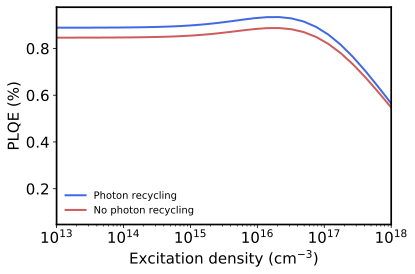

In [17]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.plot(N_ph,PLQE_ext_sim*100,color = 'royalblue',linewidth = 2,label = 'Photon recycling')
ax.plot(N_ph,PLQE_ext_sim_no_recycle*100,color = 'indianred',linewidth = 2,label = 'No photon recycling')
#ax.plot(carrier_tot, PLQE_sim*100)
#ax.plot(N_ph,PLQE_ext_sim_no_recycle*100,color = 'orange')
#ax.scatter(nn_data,PLQE_data_int*100,color = 'blue',linewidth = 2,label = 'experiment (internal)')
#ax.scatter(nn_data,PLQE_data,color = 'red',linewidth = 2,label = 'experiment (external)')
for i in iter(ax.spines.values()):
    i.set_linewidth(1.7) 
ax.set_xlabel('Excitation density (cm$^{-3}$)',fontsize = 15)
ax.set_ylabel('PLQE (%)',fontsize = 15)
ax.set_xscale('log')
ax.set_xlim(1e13,1e18)  
ax.legend(frameon = False)
#fig.savefig('PLQE_sim_plus_expt_recycling.svg', bbox_inches='tight')


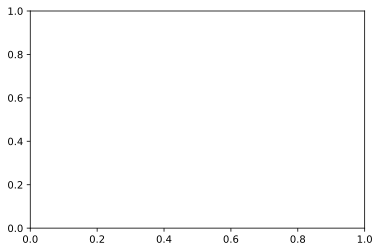

In [16]:
Reds = cm = plt.get_cmap('Reds') 
cNorm  = colors.Normalize(vmin=0, vmax=values[3])
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=Reds)




reds = cm = plt.get_cmap('Reds') 
cNorm  = colors.Normalize(vmin=0, vmax=values[2])
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=reds)
fig = plt.figure()
ax = fig.add_subplot(111)
for idx in values[3:-5]:
    colorVal = scalarMap.to_rgba(values[idx])
            #colorText = (ratios_absorption[idx])
    retLine, = ax.plot(t_data1, norm_mult*data[idx]/max(data[idx]),
            color=colorVal,s = 8)
                       #label=colorText)
    lines.append(retLine)
            #ax.scatter(t_data1, norm_mult*data[idx]/max(data[idx]),color = 'orange',s = 6)

In [18]:
check = 1/(list(init_params.values())[3]+list(init_params.values())[4]+list(init_params.values())[5])
check


244.77291050792797

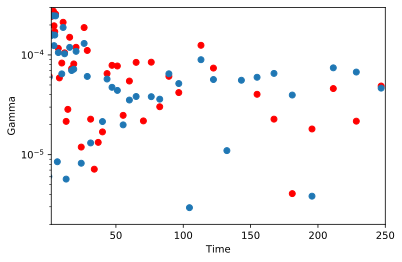

In [19]:
t_new = t_data1*1e-12
tau_a = 1100e-12

tau_s = 300e-12
YY3 = np.exp(-t_new/1100)/charge_data3
B_fuse_y3 = np.gradient(YY3,t_new)/np.exp(-t_new/tau_a)

XX3 = np.exp(-t_new/tau_s)/exciton_data3
B_fuse_x3 = np.gradient(XX3,t_new)/np.exp(-t_new/tau_s)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(t_new*1e12,B_fuse_y3,color = 'red')
ax.scatter(t_new*1e12,B_fuse_x3)
ax.set_xlabel('Time')
ax.set_ylabel('Gamma')
ax.set_yscale('log')
ax.set_xlim(2,250)
ax.set_ylim(.000002,0.0003)

matrix1 = [t_new*1e12, B_fuse_y3]


In [20]:
toClipboardForExcel(matrix1)

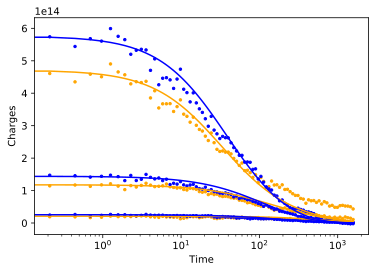

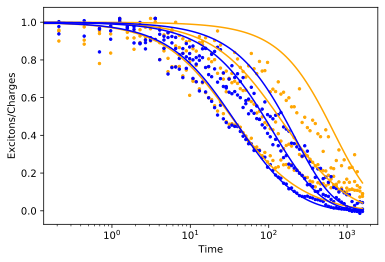

In [21]:
fig = plt.figure()
ax = fig.add_subplot(111)
values = range(len(data))
for idx in values:
    if (idx<3):
        ax.scatter(t_data1, norm_mult*data[idx],color = 'orange',s = 6)
    else:
        ax.scatter(t_data1, norm_mult*data[idx],color = 'blue',s = 6)
for var in model_fit:
    if (var == charges1):
        ax.plot(t_data1, model_fit[var],color = 'orange')
    elif(var == charges2):
        ax.plot(t_data1, model_fit[var],color = 'orange')
    elif(var == charges3):
        ax.plot(t_data1, model_fit[var],color = 'orange')
    else:
        ax.plot(t_data1, model_fit[var],color = 'blue')
ax.set_xlabel('Time')
ax.set_ylabel('Charges')
ax.set_xscale('log')
#ax.set_ylim(0,.5e22)
#ax.set_xlim(-.1,2)
fig = plt.figure()
ax = fig.add_subplot(111)
for idx in values:
    if (idx<3):
        ax.scatter(t_data1, norm_mult*data[idx]/max(data[idx]),color = 'orange',s = 6)
    else:
        ax.scatter(t_data1, norm_mult*data[idx]/max(data[idx]),color = 'blue',s = 6)
for var in model_fit:
    if (var == charges1):
        ax.plot(t_data1, model_fit[var]/max(model_fit[var]),color = 'orange')
    elif(var == charges2):
        ax.plot(t_data1, model_fit[var]/max(model_fit[var]),color = 'orange')
    elif(var == charges3):
        ax.plot(t_data1, model_fit[var]/max(model_fit[var]),color = 'orange')
    else:
        ax.plot(t_data1, model_fit[var]/max(model_fit[var]),color = 'blue')
ax.set_xlabel('Time')
ax.set_ylabel('Excitons/Charges')
ax.set_xscale('log')
#ax.set_xlim(0,1100)

In [22]:
fig = plt.figure()
ax = fig.add_subplot(111)
aa_rad = 2.941176e-04
for var in model_fit:
    if (var == charges1):
        ax.plot(t_data1, model_fit[var],color = 'orange')
    elif(var == charges2):
        ax.plot(t_data1, model_fit[var],color = 'orange')
    elif(var == charges3):
        ax.plot(t_data1, model_fit[var],color = 'orange')
    else:
ax.plot(t_data1, aa_rad*model_fit[var],color = 'blue')
ax.set_xlabel('Time')
ax.set_ylabel('Charges')
ax.set_xscale('log')

IndentationError: expected an indented block (<ipython-input-22-e18d96db381c>, line 12)

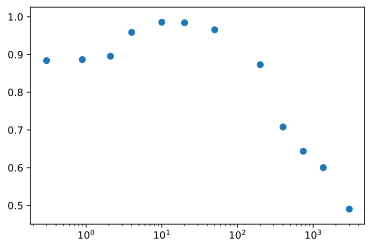

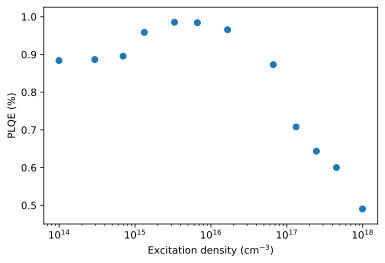

In [44]:
PLQE_data_init = np.genfromtxt('Y6_PLQE_fluence.csv',delimiter=',')
PLQE_power = PLQE_data_init[:,0]
PLQE_data = (1/3)*PLQE_data_init[:,1]
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(PLQE_power,PLQE_data)
ax.set_xscale('log')

wavelength = 530e-9
thickness = 80e-9
k = .8 #from kerremans, Armin et al. 
alpha = 4*np.pi*k/wavelength
OD = -np.log10(np.exp(-alpha*thickness))
absorb = (1-10**(-OD))
reprate = 25000
FWHM = 2e-3
power_steady = PLQE_power*1e-6
nn_data = absorb*power_steady/((h*c/wavelength)*np.pi*(FWHM/2)**2*thickness*reprate)*1e-6
Factor = absorb/((h*c/wavelength)*np.pi*(FWHM/2)**2*thickness*reprate)*1e-6


fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(nn_data,PLQE_data)
ax.set_xscale('log')
ax.set_xlabel('Excitation density (cm$^{-3}$)')
ax.set_ylabel('PLQE (%)')
fig.savefig('PLQE_data.svg', bbox_inches='tight')


In [47]:
Factor

3.315276996965746e+20

In [ ]:
wavelength = 700e-9
thickness = 120e-9
k = 1.3 #from kerremans, Armin et al. 
alpha = 4*np.pi*k/wavelength
OD = -np.log10(np.exp(-alpha*thickness))
absorb = (1-10**(-OD))
reprate = 3000
FWHM = 400e-6
power1 = 18e-6

nn1 = absorb*.9*power1/((h*c/wavelength)*np.pi*(FWHM/2)**2*reprate*thickness)*1e-9

nn1*1e-14

In [ ]:
wavelength = 512e-9
thickness = 80e-9
k = 0.4 #from kerremans, Armin et al. 
alpha = 4*np.pi*k/wavelength
OD = -np.log10(np.exp(-alpha*thickness))
absorb = (1-10**(-OD))
reprate = 40000
FWHM = 60e-6
power1 = 5e-6

nn1 = absorb*1*power1/((h*c/wavelength)*np.pi*(FWHM/2)**2*reprate*thickness)*1e-9

nn1*1e-14

In [ ]:
list(init_params.values())[:]

In [18]:

#a_c = Parameter('a_c',value =1/(3230),min = 0,absolute_sigma = False, fixed =True)
#b_fuse = Parameter('b_fuse', value = 2.2e-8*1e-12*1e3,min = 0,absolute_sigma = False, fixed = True)#1.45e-11*1e12
#b_fuse_t = Parameter('b_fuse_t', value = 1.35e-11*1e-12*1e3,min = 0,absolute_sigma = False, fixed = False)#1.45e-11*1e12
#C_c = Parameter('C_c', value =0,min = 0,fixed = True)#.000551e-28,min = 0,fixed = True)
#b_ex_c = Parameter('b_ex_c', value =100e-11*1e-12*1e3,min = 0,absolute_sigma = False,fixed = True)#.495e-11,min = 0,fixed = False)
#a_ex_non =Parameter('a_ex_non', value = (1/(505)),min = 0,absolute_sigma = False,fixed = False)#1/(280)
#a_split = Parameter('a_split', value =(1/(2000)),min = 0,absolute_sigma = False,fixed = True)#1/(120e-12)
#b_ex = Parameter('b_ex', value = 5.5e-8*1e-12*1e3,min = 0,absolute_sigma = False,fixed = True)##2.2e-11*1e12
#C_ex = Parameter('C_ex',value = 0,min = 0,fixed = True)#.000551e-28,min = 0,fixed = True)
#a_ex_rad = Parameter('a_ex_rad',value =1/1400,min = 0,fixed = True)#1e6,min = 0,fixed = True)


# init_params = OrderedDict([('C_c', 0),
#              ('C_ex', 0),
#              ('b_non', 3.5e-8*1e-12*1e3),
#              ('a_c', 1/1100),
#              ('a_ex_non', 1/345),
#              ('a_ex_rad', 1/3600),
#              ('b_ex', 2.4e-8*1e-12*1e3), 
#              ('a_split', 1/2000),
#              ('b_ex_c', 3.4e-8*1e-12*1e3),
#              ('b_fuse', 3e-8*1e-12*1e3)])


eta_esc= .30

# C_c = list(init_params.values())[0]  #.00002e-28
# C_ex = list(init_params.values())[1] #0.00002e-28
# a_c = list(init_params.values())[2]*1e12  #1/(1030e-12)
# a_ex_non_rad = list(init_params.values())[3]*1e12  #1/(510e-12)
# a_ex_rad = list(init_params.values())[4]*1e12  #1/(1200e-12)
# a_split = 1/(500e-12)#list(init_params.values())[5] *1e12 #1/(500e-12)
# b_ex = list(init_params.values())[6]*1e9  #5500e-11
# b_ex_c = list(init_params.values())[7]*1e9 #100e-11
# b_fuse = list(init_params.values())[8]*1e9# 1.7e-8

C_c = 0 #.00002e-28
C_ex = 0 #list(init_params.values())[1] #0.00002e-28
a_c = 1/1000*1e12 #list(init_params.values())[2]*1e12  #1/(1030e-12)
a_ex_non_rad =1/345*1e12 # list(init_params.values())[3]*1e12  #1/(510e-12)
a_ex_rad = 1/3600*1e12 #list(init_params.values())[4]*1e12  #1/(1200e-12)
a_split = 1/2000*1e12 # 1/(500e-12)#list(init_params.values())[5] *1e12 #1/(500e-12)
b_ex =1e-8*1e-12*1e3*1e9  # list(init_params.values())[6]*1e9  #5500e-11
b_ex_c = 1.4e-8*1e-12*1e3*1e9 #list(init_params.values())[7]*1e9 #100e-11
b_fuse = 3e-8*1e-12*1e3*1e9  #list(init_params.values())[8]*1e9# 1.7e-8
#b_fuse_t = 3*b_fuse



#*eta_esc

a_ex = a_split+a_ex_rad+a_ex_non_rad

def dP_dt(P,t,G):
    G1 = G[0]
    G2 = G[1]
    return [-(a_c*P[0]+4*b_fuse*P[0]**2-b_ex*P[1]**2+C_c*P[0]**3-2*a_split*P[1]-G1),-(b_ex_c*P[0]*P[1]-G2+a_ex*P[1]+b_ex*P[1]**2+C_ex*P[1]**3-.5*b_fuse*P[0]**2)]

ts = np.linspace(0, 1e-6, 60)

N_ph = 1e16*np.logspace(1,10,num = 50)*1e-6
R_init = .4
PLQE_sim = []
charge_ratio = []
for nn in N_ph:
    P0 = [nn*R_init, nn*(1-R_init)]
    G = [P0[0]/600e-12,P0[1]/600e-12]
    Ps = odeint(dP_dt, P0, ts, args = (G,))
    charges = Ps[:,0]
    excitons = Ps[:,1]
    PLQE_theory_n = ((a_ex_rad*excitons)/(a_c*charges+C_c*charges**3+b_ex_c*charges*excitons-2*a_split*excitons+.5*b_fuse*charges**2-.5*b_fuse*charges**2+4*b_fuse*charges**2+a_ex*excitons+C_ex*excitons**3))
    charge_ratio = np.append(charge_ratio,(charges[-1]/(charges[-1]+excitons[-1])))
    PLQE_sim = np.append(PLQE_sim,PLQE_theory_n[-1])
    
PLQE_ext_sim = PLQE_sim*eta_esc/(1-PLQE_sim+PLQE_sim*eta_esc)
PLQE_ext_sim_no_recycle = PLQE_sim*eta_esc
PLQE_1 = PLQE_sim/max(PLQE_sim)

PLQE_matrix = [PLQE_1,PLQE_2,PLQE_3,PLQE_4,PLQE_5,PLQE_6,PLQE_7]



# fig = plt.figure()
# ax = fig.add_subplot(111)
# ax.plot(N_ph,PLQE_1)#.4
# ax.plot(N_ph,PLQE_2)#.5
# ax.plot(N_ph,PLQE_3)#.6
# ax.plot(N_ph,PLQE_4)#.7
# ax.plot(N_ph,PLQE_5)#.8
# ax.plot(N_ph,PLQE_6)#.9
# ax.plot(N_ph,PLQE_7)#1
fraction = [0,10,20,30,40,50,60]

fig = plt.figure()
ax = fig.add_subplot(111)
values = range(7)
Reds = cm = plt.get_cmap('plasma') 
cNorm  = colors.Normalize(vmin=0, vmax=values[-1]+1)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=Reds)
lines = []
for idx in values:
    colorVal = scalarMap.to_rgba(values[idx])
    colorText = (fraction[idx])
    retLine = ax.plot(N_ph, PLQE_matrix[idx],
            color=colorVal,linewidth = 3,
                       label=colorText)
    lines.append(retLine)




#ax.scatter(nn_data,PLQE_data/max(PLQE_data))
#ax.plot(N_ph,charge_ratio)

ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_xlabel('Excitation density (cm$^{-3}$)',fontsize = 15)
ax.set_ylabel('PLQE (Normalised)',fontsize = 15)
ax.set_xscale('log')
ax.set_xlim(1e13,1e18)  
for i in iter(ax.spines.values()):
    i.set_linewidth(1.7) 
handles,labels = ax.get_legend_handles_labels()
ax.legend(handles, labels,frameon = False,title="% Free Charge")#loc='lower right'
#ax.set_yscale('log')
ax.set_ylim(0e-1,1.05)
fig.savefig('PLQE_explainer.svg', bbox_inches='tight')

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(N_ph,charge_ratio*100)
ax.set_xlabel('n')
ax.set_ylabel('Charge %')
ax.set_xscale('log')
ax.set_xlim(1e13,1e18)  

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(N_ph,PLQE_sim*100,color = 'blue')
ax.plot(N_ph,PLQE_ext_sim*100,color = 'red')
ax.plot(N_ph,PLQE_ext_sim_no_recycle*100,color = 'orange')
ax.scatter(nn_data,PLQE_data)

#ax.plot(N_ph,charge_ratio)
ax.set_xlabel('n')
ax.set_ylabel('PLQE')
ax.set_xscale('log')
ax.set_xlim(1e13,1e18)  
print(max(PLQE_sim))
     

NameError: name 'PLQE_2' is not defined

In [ ]:
1/(a_ex)*1e12

(10000000000000.0, 1e+18)

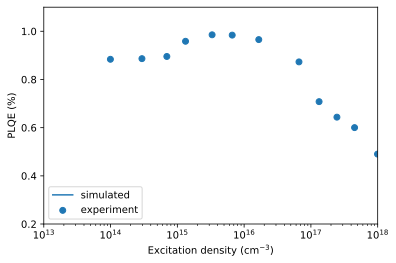

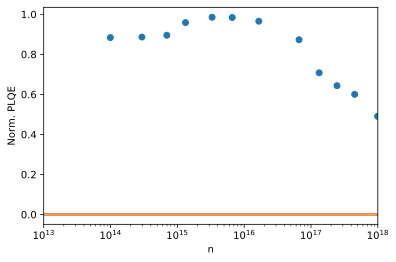

In [19]:
###Simple model just bimolecular and monomolecular

C_c = list(init_params.values())[0]  #.00002e-28
C_ex = list(init_params.values())[1] #0.00002e-28
a_c = list(init_params.values())[2]*1e12  #1/(1030e-12)
a_ex_non_rad = list(init_params.values())[3]*1e12  #1/(510e-12)
a_ex_rad = list(init_params.values())[4]*1e12  #1/(1200e-12)
a_split = list(init_params.values())[5] *1e12 #1/(500e-12)
b_ex = list(init_params.values())[6]*1e9  #5500e-11
b_ex_c = list(init_params.values())[7]*1e9 #100e-11
b_fuse = list(init_params.values())[8]*1e9# 1.7e-8
b_non = list(init_params.values())[9]*1e9
eta_esc= .3


def dP_dt(P,t,G):
    G1 = G[0]
    G2 = G[1]
    return [-(a_c*P[0]+(b_fuse+b_non)*P[0]**2-b_ex*P[1]**2+C_c*P[0]**3-2*a_split*P[1]-G1),-(b_ex_c*P[0]*P[1]-G2+a_ex*P[1]+b_ex*P[1]**2+C_ex*P[1]**3-.5*b_fuse*P[0]**2)]

ts = np.linspace(0, 1e-6, 60)

N_ph = 1e16*np.logspace(1,10,num = 30)*1e-6
R_init = .45
PLQE_sim = []
charge_ratio = []
for nn in N_ph:
    P0 = [nn*R_init, nn*(1-R_init)]
    G = [P0[0]/600e-12,P0[1]/600e-12]
    Ps = odeint(dP_dt, P0, ts, args = (G,))
    charges = Ps[:,0]
    excitons = Ps[:,1]
    PLQE_theory_n = ((a_ex_rad*excitons)/(a_c*charges+C_c*charges**3+b_ex_c*charges*excitons-2*a_split*excitons+b_non*charges**2+a_ex*excitons+C_ex*excitons**3))
    charge_ratio = np.append(charge_ratio,(charges[-1]/(charges[-1]+excitons[-1])))
    PLQE_sim = np.append(PLQE_sim,PLQE_theory_n[-1])
    
PLQE_ext_sim = PLQE_sim*eta_esc/(1-PLQE_sim+PLQE_sim*eta_esc)
PLQE_ext_sim_no_recycle = PLQE_sim*eta_esc


#n = 1e19*np.logspace(1,10)*1e-6

#PLQE_int = (a_rad*excitons+b_rad*charges**2)/((a_non+a_rad)*excitons+b_rad*charges**2+b_non*excitons**2)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(N_ph,PLQE_ext_sim*100, label = 'simulated')
ax.scatter(nn_data,PLQE_data,label = 'experiment')
#ax.plot(N_ph,charge_ratio)
ax.set_xlabel('Excitation density (cm$^{-3}$)')
ax.set_ylabel('PLQE (%)')
ax.set_xscale('log')
ax.set_xlim(1e13,1e18)  
#ax.set_yscale('log')
ax.set_ylim(2e-1,1.1)
#ax.set_xlim(1e14,1e19)
ax.legend(loc = 3)
fig.savefig('PLQE_with_TA_fit.svg', bbox_inches='tight')

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(N_ph,PLQE_sim*100,color = 'blue')
ax.plot(N_ph,PLQE_ext_sim*100,color = 'red')
ax.plot(N_ph,PLQE_ext_sim_no_recycle*100,color = 'orange')
ax.scatter(nn_data,PLQE_data,label = 'experiment')
ax.set_xlabel('n')
ax.set_ylabel('Norm. PLQE')
ax.set_xscale('log')
ax.set_xlim(1e13,1e18)  

#ax.set_yscale('log')
#ax.set_ylim(2e-1,1.1)

ValueError: x and y must have same first dimension, but have shapes (30,) and (0,)

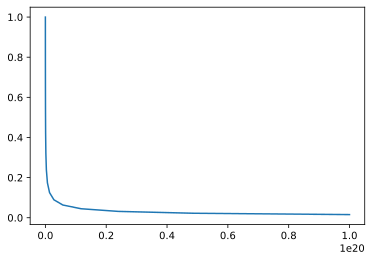

In [24]:
Ex_eff_m =.17 #units of m_e

eps_r = 5.0
E_b = 1000*(Ex_eff_m*(1/eps_r**2)*m_e*e_charge**4/(2*(4*np.pi*ε_0*hbar)**2))/eV
#E_b= 35

E_b_J = E_b*eV/1000

T = 300
nn = N_ph*1e6

const = ((2*np.pi*Ex_eff_m*m_e*k_b*T/(h**2))**1.5)*(np.exp(-(E_b_J)/(k_b*T)))

aa= (1/nn)*const

xx = .5*(np.sqrt(aa)*np.sqrt(aa+4)-aa)

fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(nn*1e-6,xx)
ax.plot(N_ph,charge_ratio)
#ax.plot(N_ph,(charge_ratio-0.4)/max(charge_ratio-.4))
ax.set_xlabel('Excitation density (cm$^{-3}$)')
ax.set_ylabel('Free Charge fraction')
ax.set_xscale('log')

In [20]:
mu_e = 0.004 #1.8e-4 #cm^2s-1V-1 from philip's delocalisation paper
mu_h = 5.6e-4 #0.05 #
langevin_beta = e_charge*(mu_e+mu_h)/(eps_r*ε_0)

beta_recomb = 4*b_fuse

ratio = beta_recomb/(mu_h+mu_e)/(e_charge/(eps_r*ε_0)) #*eps_r**(-1)

Diff = mu_h*1e-4*k_b*T/e_charge
L_d = np.sqrt((6*Diff*1000e-12))

print(langevin_beta, beta_recomb, ratio,L_d*1e9)

1.6502756227278674e-11 4*b_fuse 242383753653.714*b_fuse 2.9472477424419767


In [208]:
D_2 = beta_recomb*1e-6/(8*np.pi*1.5e-9)
L_d_2 = (6*D_2*1030*1e-12)**.5
print(L_d_2*1e9)

120.10746871801682


In [82]:
(1/(0.07/280))

4000.0

In [215]:
D_compare = 2*b_ex*1e-6/(8*np.pi*1.5e-9)
L_d_exciton = (D_compare*260*1e-12)**.5
print(L_d_exciton*1e9)

27.54339416396185


In [114]:
error = np.sqrt((((0.08)*np.sqrt(275)))**2+(500/600)**2)
error

0.015303862932600292